In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.3.0


In [2]:
dataset_path = 'apartment/Residential_16_NoWeather.csv'


In [3]:
raw_dataset = pd.read_csv(dataset_path)
raw_dataset.pop('date')

dataset = raw_dataset.copy()
dataset.tail()


,temperature,humidity,pressure,dc_output,ac_output,energy_kWh
11390,2.6,59.0,102.81,0.0,0.0,1.15
11391,2.4,61.0,102.77,0.0,0.0,1.00
11392,2.1,63.0,102.74,0.0,0.0,0.83
11393,1.9,66.0,102.73,0.0,0.0,1.01
11394,1.7,68.0,102.68,0.0,0.0,1.03


In [4]:
dataset.isna().sum()


temperature       0
humidity          0
pressure          0
dc_output         0
ac_output         0
energy_kWh     1361
dtype: int64

In [5]:
dataset = dataset.dropna()


In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)


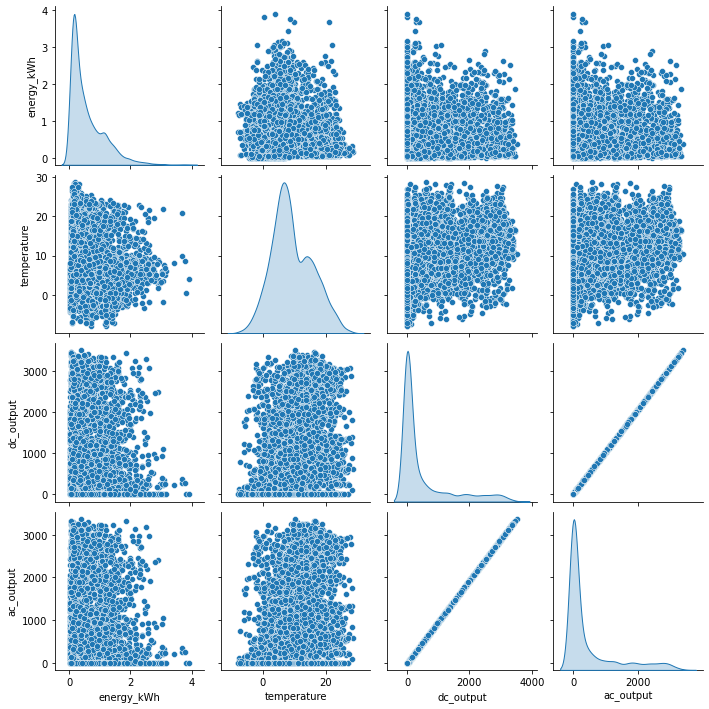

In [7]:
sns.pairplot(train_dataset[["energy_kWh", "temperature", "dc_output", "ac_output"]], diag_kind="kde")


In [8]:
train_stats = train_dataset.describe()
train_stats.pop("energy_kWh")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
temperature,8027.0,9.198219,6.459305,-8.00,4.80,8.10,13.9000,28.800
humidity,8027.0,82.273452,12.652325,27.00,74.00,85.00,93.0000,100.000
pressure,8027.0,101.678133,0.795896,98.61,101.21,101.71,102.1800,103.940
dc_output,8027.0,490.511671,848.893518,0.00,0.00,0.00,562.0310,3508.898
ac_output,8027.0,467.550887,817.423892,0.00,0.00,0.00,528.3145,3371.073


In [9]:
train_labels = train_dataset.pop('energy_kWh')
test_labels = test_dataset.pop('energy_kWh')


In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [11]:
def build_model():
  model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


In [12]:
model = build_model()


In [13]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               3072      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 77,057
Trainable params: 77,057
Non-trainable params: 0
_________________________________________________________________


In [14]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result


array([[ 0.01738038],
       [-0.00308865],
       [ 0.01538351],
       [ 0.10174589],
       [ 0.10091007],
       [ 0.08205423],
       [ 0.1233677 ],
       [ 0.08490917],
       [ 0.09186887],
       [ 0.07280383]], dtype=float32)

In [15]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 2000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
1995,0.066978,0.179962,0.066978,0.407060,0.435255,0.407060,1995
1996,0.065888,0.178346,0.065888,0.385946,0.426402,0.385946,1996
1997,0.066852,0.179885,0.066852,0.383324,0.430828,0.383324,1997
1998,0.066686,0.176980,0.066686,0.403345,0.434224,0.403345,1998
1999,0.068031,0.178150,0.068031,0.394948,0.433314,0.394948,1999


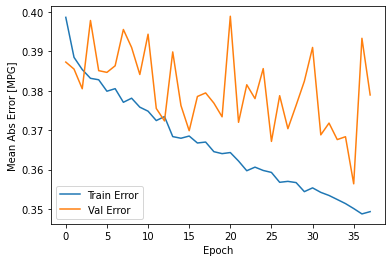

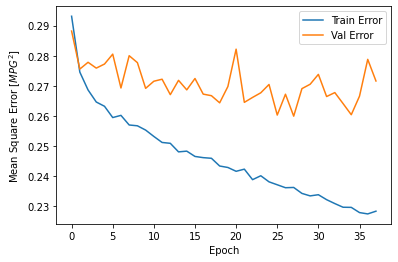

In [24]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)



.......................................

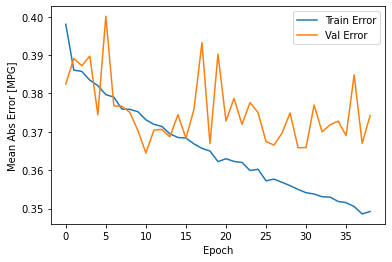

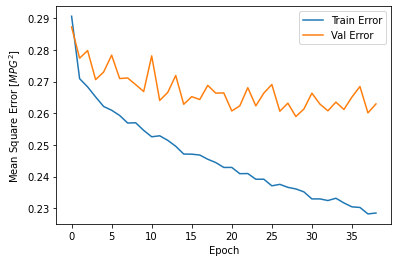

In [25]:
model = build_model()

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


63/63 - 0s - loss: 0.2364 - mae: 0.3592 - mse: 0.2364
Testing set Mean Abs Error:  0.36 MPG


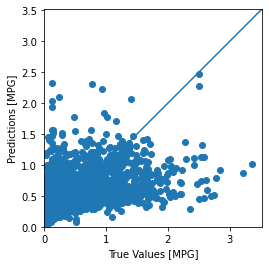

In [20]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


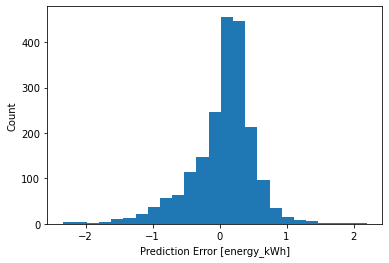

In [21]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [energy_kWh]")
_ = plt.ylabel("Count")
